# California Dataset Description

## Reading the I5-N3 dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

cali_dataset_2015 = pd.read_csv("datasets/california_paper_eRCNN/I5-N-3/2015.csv")

In [2]:
cali_dataset_2015.head()


,timestep,road_section,flow,density,speed
0,0,0,213.0,2.3,64.6
1,0,1,87.0,0.6,68.8
2,0,2,81.6,0.5,72.8
3,0,3,68.0,0.5,72.2
4,0,4,102.0,0.6,69.1


In [3]:
cali_dataset_2015.describe()

,timestep,road_section,flow,density,speed
count,2.835000e+06,2.835000e+06,2.835000e+06,2.835000e+06,2.835000e+06
mean,5.249950e+04,1.300000e+01,9.641383e+02,7.627407e+00,6.436832e+01
std,3.031089e+04,7.788882e+00,5.244485e+02,6.054094e+00,9.542847e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,2.624975e+04,6.000000e+00,4.940000e+02,3.400000e+00,6.300000e+01
50%,5.249950e+04,1.300000e+01,1.051200e+03,6.800000e+00,6.660000e+01
75%,7.874925e+04,2.000000e+01,1.365600e+03,9.600000e+00,6.970000e+01
max,1.049990e+05,2.600000e+01,2.730000e+03,7.580000e+01,8.620000e+01


## Creating Image Dataset

In [5]:
class STImageDataset(torch.utils.data.Dataset):
    def __init__(self, data_file_name, image_size=72, data_size=0, pred_window=3, transforms=None):
        self.data = pd.read_csv(data_file_name)
        self.data = self.data.to_numpy()

        if data_size == 0:
            data_size = len(np.unique(self.data[:,0])) - image_size - pred_window
            #print(len(np.unique(self.data[:,0])))
        else:
            self.data = self.data[:data_size + image_size]

        self.detect_num = int(np.max(self.data[:, 1])+1)
        self.image_size = image_size
        self.data_size = data_size
        self.pred_window = pred_window
        self.transforms = transforms

    def __len__(self):
        return self.data_size

    def __getitem__(self, idx):
        image = self.data[idx * self.detect_num:(idx + self.image_size) * self.detect_num, 2:]
        image = torch.from_numpy(image.astype(np.float32))
        image = torch.reshape(image, (self.image_size, self.detect_num, -1))
        image = image.permute(2, 1, 0)
        label = self.data[((idx + self.image_size + self.pred_window) * self.detect_num)+int(self.detect_num/2), 2:]
        label = torch.from_numpy(label.astype(np.float32))

        if self.transforms:
            image = self.transforms(image)

        return image, label


train_data_file_name = "datasets/california_paper_eRCNN/I5-N-3/2015.csv"
train_set = STImageDataset(train_data_file_name)
test_data_file_name = "datasets/california_paper_eRCNN/I5-N-3/2016.csv"
test_set = STImageDataset(test_data_file_name)
print(f"Size of train_set = {len(train_set)}")
print(f"Size of test_set = {len(test_set)}")

Size of train_set = 104925
Size of test_set = 104925


torch.Size([3, 27, 72])
tensor([[213.0000, 249.0000, 369.0000,  ..., 297.0000, 270.0000, 942.0000],
        [ 87.0000, 195.0000, 285.0000,  ..., 237.0000, 198.0000, 786.0000],
        [ 81.6000, 127.2000, 240.0000,  ..., 199.2000, 230.4000, 657.6000],
        ...,
        [271.2000, 297.6000, 489.6000,  ..., 309.6000, 357.6000, 784.8000],
        [120.0000, 154.0000, 236.0000,  ..., 206.0000, 228.0000, 704.0000],
        [139.2000, 168.0000, 240.0000,  ..., 256.8000, 280.8000, 794.4000]])
tensor(1456.)
tensor(349.4664)
tensor([804.0000,   5.7000,  66.0000])


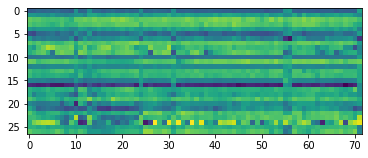

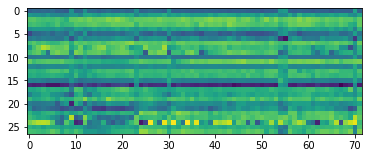

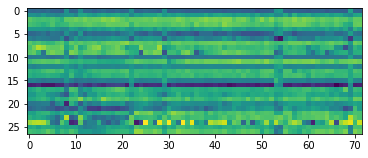

In [6]:
image, label = train_set[0]
print(image.shape)
print(image[0])
print(image[0].max())
print(image[0].mean())
print(label)

for i in range(3):
    image, label = train_set[i]
    img = (image[2]/image[2].max())
    plt.imshow(img)
    plt.show()

## Creating the CNN Model

In [27]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # Conv Layer 1
        self.conv1 = nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels,
            kernel_size=(3, 3), stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Conv Layer 2
        self.conv2 = nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=(3, 3), stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection to downsample residual
        # In case the output dimensions of the residual block is not the same
        # as it's input, have a convolutional layer downsample the layer
        # being bought forward by approporate striding and filters
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels=in_channels, out_channels=out_channels,
                    kernel_size=(1, 1), stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out

class CNN(nn.Module):
    def __init__(self, in_channels=3, height=27, width=72):
        super(CNN, self).__init__()

        # Create blocks
        self.block1 = self._create_block(in_channels, 32, stride=1)
        self.block2 = self._create_block(32, 64, stride=1)
        self.block3 = self._create_block(64, 96, stride=1)
        self.linear1 = nn.Linear(96*height*width, 2048)
        self.drop = nn.Dropout(p=0.6)
        self.linear2 = nn.Linear(2048, 1024)
        self.linear_out = nn.Linear(1024, 1)

    # A block is just two residual blocks for ResNet18
    def _create_block(self, in_channels, out_channels, stride):
        return nn.Sequential(
            ResidualBlock(in_channels, out_channels, stride),
            ResidualBlock(out_channels, out_channels, 1),
            ResidualBlock(out_channels, out_channels, 1)
        )

    def forward(self, x):
	# Output of one layer becomes input to the next
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = out.view(out.size(0), -1)
        out = nn.ReLU()(self.linear1(out))
        out = self.drop(out)
        out = nn.ReLU()(self.linear2(out))
        out = self.linear_out(out)
        return out

model = CNN(3,27,72)
model = model.float()

## Training the CNN


In [28]:
from torch import optim
import time
# Define Dataloader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=50, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=50, shuffle=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")     #Check whether a GPU is present.

model.to(device)   #Put the network on GPU if present

criterion = nn.MSELoss() # L2 Norm
optimizer = optim.Adam(model.parameters(), lr=1e-3) # ADAM with lr=10^-4
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1) # exponential decay every epoch = 2000iter

for epoch in range(10): #10 epochs
    losses = []
    scheduler.step()
    # Train
    start = time.time()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        targets=targets[2]
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()                 # Zero the gradients

        outputs = model(inputs.float())                 # Forward pass
        loss = criterion(outputs, targets)    # Compute the Loss
        loss.backward()                       # Compute the Gradients

        #nn.utils.clip_grad_norm(model.parameters(), 40) # gradient cliping norm for ercnn
        optimizer.step()                      # Updated the weights
        losses.append(loss.item())
        end = time.time()

        if batch_idx % 100 == 0:
          print('Batch Index : %d Loss : %.3f Time : %.3f seconds ' % (batch_idx, np.mean(losses), end - start))

          start = time.time()
    # Evaluate
    model.eval()
    total = 0
    losses_test = []

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            targets=targets[2]
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs.float())                 # Forward pass
            loss = criterion(outputs, targets)    # Compute the Loss

            losses_test.append(loss.item())

            if batch_idx % 100 == 0:
                print('Batch Index : %d Loss : %.3f' % (batch_idx, np.mean(losses)))

        print('--------------------------------------------------------------')
    model.train()

C:\Users\jose0\anaconda3\envs\CUTMaC-CloudApps\lib\site-packages\torch\optim\lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
C:\Users\jose0\anaconda3\envs\CUTMaC-CloudApps\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Batch Index : 0 Loss : 682723.375 Time : 47.108 seconds 
Batch Index : 100 Loss : 258958.012 Time : 2878.389 seconds 


KeyboardInterrupt: 

## Creating Image Series Dataset

In [8]:
class STImgSerieDataset(torch.utils.data.Dataset):
    def __init__(self, data_file_name, seq_size=72, image_size=72, data_size=0, pred_window=3,transforms=None):
        self.data = pd.read_csv(data_file_name)
        self.data = self.data.to_numpy()
        self.detect_num = int(np.max(self.data[:, 1])+1)

        if data_size == 0:
            data_size = len(np.unique(self.data[:,0])) - seq_size - image_size - pred_window
            #print(len(np.unique(self.data[:,0])))
        else:
            self.data = self.data[:(data_size + seq_size + image_size + pred_window) * self.detect_num]

        self.var_num = self.data.shape[1]-2
        self.seq_size = seq_size
        self.image_size = image_size
        self.data_size = data_size
        self.pred_window = pred_window
        self.transforms = transforms

    def __len__(self):
        return self.data_size

    def __getitem__(self, idx):
        image_seq=[]
        labels_seq=[]
        for sq in range(self.seq_size):
            image = self.data[(idx + sq) * self.detect_num:(idx + sq + self.image_size) * self.detect_num, 2:]
            image = torch.from_numpy(image.astype(np.float32))
            image = torch.reshape(image, (self.image_size, self.detect_num, -1))
            image = image.permute(2, 1, 0)
            image.unsqueeze_(0)
            label = self.data[((idx + sq + self.image_size + self.pred_window) * self.detect_num)+int(self.detect_num/2), 2:]
            label = torch.from_numpy(label.astype(np.float32))
            label.unsqueeze_(0)
            image_seq.append(image)
            labels_seq.append(label)
        image_seq=torch.cat(image_seq, out=torch.Tensor(self.seq_size, self.var_num, self.detect_num, self.image_size))
        labels_seq=torch.cat(labels_seq)
        if self.transforms:
            image_seq = self.transforms(image_seq)

        return image_seq, labels_seq


train_data_file_name = "datasets/california_paper_eRCNN/I5-N-3/2015.csv"
train_set = STImgSerieDataset(train_data_file_name)
test_data_file_name = "datasets/california_paper_eRCNN/I5-N-3/2016.csv"
test_set = STImgSerieDataset(test_data_file_name)
print(f"Size of train_set = {len(train_set)}")
print(f"Size of test_set = {len(test_set)}")

Size of train_set = 104853
Size of test_set = 104853


In [9]:
image, label = train_set[0]
print(image.shape)
print(image[0])
print(image[0].max())
print(image[0].mean())
print(label.shape)
print(label)

# for i in range(3):
#     image, label = train_set[i]
#     img = (image[2]/image[2].max())
#     plt.imshow(img)
#     plt.show()

torch.Size([72, 3, 27, 72])
tensor([[[2.1300e+02, 2.4900e+02, 3.6900e+02,  ..., 2.9700e+02,
          2.7000e+02, 9.4200e+02],
         [8.7000e+01, 1.9500e+02, 2.8500e+02,  ..., 2.3700e+02,
          1.9800e+02, 7.8600e+02],
         [8.1600e+01, 1.2720e+02, 2.4000e+02,  ..., 1.9920e+02,
          2.3040e+02, 6.5760e+02],
         ...,
         [2.7120e+02, 2.9760e+02, 4.8960e+02,  ..., 3.0960e+02,
          3.5760e+02, 7.8480e+02],
         [1.2000e+02, 1.5400e+02, 2.3600e+02,  ..., 2.0600e+02,
          2.2800e+02, 7.0400e+02],
         [1.3920e+02, 1.6800e+02, 2.4000e+02,  ..., 2.5680e+02,
          2.8080e+02, 7.9440e+02]],

        [[2.3000e+00, 2.6000e+00, 3.1000e+00,  ..., 2.8000e+00,
          2.8000e+00, 6.0000e+00],
         [6.0000e-01, 1.3000e+00, 1.7000e+00,  ..., 1.4000e+00,
          1.3000e+00, 4.9000e+00],
         [5.0000e-01, 8.0000e-01, 1.3000e+00,  ..., 1.1000e+00,
          1.2000e+00, 3.9000e+00],
         ...,
         [1.8000e+00, 1.8000e+00, 2.8000e+00,  ...,

## The eRCNN Model

In [65]:
import torch.nn as nn

class eRCNN(nn.Module):
    def __init__(self, input_size, hid_error_size, output_size):
        super().__init__()

        self.hid_error_size = hid_error_size

        self.conv = nn.Conv2d(
            in_channels=input_size,
            out_channels=32,
            kernel_size=(3, 3),
            stride=1
        )
        self.lin_input = nn.Linear(12*35*32, 256)  # 32 (25*70) Feature maps after AvgPool2d(2)
        self.lin_error = nn.Linear(hid_error_size, 32)
        self.lin_out = nn.Linear(256 + 32, output_size)

    def forward(self, input, error):
        out_in = nn.ReLU()(self.conv(input))
        out_in = nn.AvgPool2d(2)(out_in)  # Average Pooling with a square kernel_size=(2,2) and stride=kernel_size=(2,2)
        out_in = out_in.view(-1, self.num_flat_features(out_in))
        out_in = nn.ReLU()(self.lin_input(out_in))
        out_err = nn.ReLU()(self.lin_error(error))
        combined = torch.cat((out_in, out_err), 1)
        output = self.lin_out(combined)

        return output

    def initError(self, batch_size):
        return torch.zeros(batch_size, self.hid_error_size)

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


n_hidden = 6
e_rcnn = eRCNN(3, n_hidden, 1)


## Training eRCNN

In [67]:
from torch import optim
import time
# Define Dataloader
batch_size = 50
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")     #Check whether a GPU is present.

e_rcnn.to(device)   #Put the network on GPU if present

criterion = nn.MSELoss() # L2 Norm
optimizer = optim.Adam(e_rcnn.parameters(), lr=1e-3) # ADAM with lr=10^-4
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1) # exponential decay every epoch = 2000iter


for epoch in range(10): #10 epochs
    torch.autograd.set_detect_anomaly(True)
    losses = []
    scheduler.step()
    # Train
    start = time.time()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.permute(1, 0, 2, 3, 4)
        targets = targets.permute(1,0,2)
        #print(targets.shape)
        targets=targets[:,:,2]
        targets = torch.unsqueeze(targets, 2)
        #print(targets.shape)
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()                 # Zero the gradients

        error = e_rcnn.initError(batch_size)
        # print(inputs.shape)
        # print(inputs[i].shape)
        # print(targets.shape)
        # print(error.shape)
        # e_rcnn.zero_grad()
        loss = torch.zeros(1, requires_grad=True)
        for i in range(inputs.shape[0]):
            outputs = e_rcnn(inputs[i], error.detach())
            err_i = outputs - targets[i]
            error = torch.cat((error[:,1:], err_i), 1)
            #loss = loss + criterion(outputs, targets[i])  # Loss function Option 2

        #loss = criterion(outputs, targets[-1])    # Compute the Loss
        #loss /= inputs.shape[0]
        loss = criterion(outputs, targets[i])
        loss.backward()
        #print(f"BTT of Batch: {batch_idx}")# Compute the Gradients

        nn.utils.clip_grad_norm(e_rcnn.parameters(), 40) # gradient cliping norm for ercnn
        optimizer.step()                      # Updated the weights
        losses.append(loss.item())
        end = time.time()

        if batch_idx % 100 == 0:
            print('Batch Index : %d Loss : %.3f Time : %.3f seconds ' % (batch_idx, np.mean(losses), end - start))
            start = time.time()

    # Evaluate
    e_rcnn.eval()
    total = 0
    losses_test = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs = inputs.permute(1, 0, 2, 3, 4)
            targets = targets.permute(1,0,2)
            targets=targets[:,:,2]
            targets = torch.unsqueeze(targets, 2)
            inputs, targets = inputs.to(device), targets.to(device)

            error = e_rcnn.initError(batch_size)
            for i in range(inputs.shape[0]):
                outputs = e_rcnn(inputs[i], error.detach())
                err_i = outputs - targets[i]
                error = torch.cat((error[:,1:], err_i), 1)

            loss = criterion(outputs, targets[i])
            losses_test.append(loss.item())
            if batch_idx % 100 == 0:
                print('Batch Index : %d Loss : %.3f' % (batch_idx, np.mean(losses_test)))

    print('--------------------------------------------------------------')
    e_rcnn.train()

C:\Users\jose0\anaconda3\envs\CUTMaC-CloudApps\lib\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
C:\Users\jose0\anaconda3\envs\CUTMaC-CloudApps\lib\site-packages\ipykernel_launcher.py:53: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


BTT of Batch: 0
Batch Index : 0 Loss : 223.763 Time : 10.150 seconds 
BTT of Batch: 1
BTT of Batch: 2
BTT of Batch: 3
BTT of Batch: 4
BTT of Batch: 5
BTT of Batch: 6
BTT of Batch: 7
BTT of Batch: 8
BTT of Batch: 9
BTT of Batch: 10


KeyboardInterrupt: 